# Challenge

1. Load the houseprices data from Thinkful's database.
2. Do data cleaning, exploratory data analysis, and feature engineering. You can use your previous work in this module. But make sure that your work is satisfactory.
3. Now, split your data into train and test sets where 20% of the data resides in the test set.
4. Build several linear regression models including Lasso, Ridge, or ElasticNet and train them in the training set. Use k-fold cross-validation to select the best hyperparameters if your models include one!
5. Evaluate your best model on the test set.
6. So far, you have only used the features in the dataset. However, house prices can be affected by many factors like economic activity and the interest rates at the time they are sold. So, try to find some useful factors that are not included in the dataset. Integrate these factors into your model and assess the prediction performance of your model. Discuss the implications of adding these external variables into your model.

In [1]:
import numpy as np
import pandas as pd
from sklearn import linear_model
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from statsmodels.tools.eval_measures import mse, rmse
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')

### Loading the Data from the Thinkful PostgreSql Database

In [2]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))
hprice = pd.read_sql_query('select * from houseprices',con=engine)

engine.dispose()

### Exploring the Data

In [3]:
pd.set_option('display.max_columns', None)
hprice.head(10)

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,lotconfig,landslope,neighborhood,condition1,condition2,bldgtype,housestyle,overallqual,overallcond,yearbuilt,yearremodadd,roofstyle,roofmatl,exterior1st,exterior2nd,masvnrtype,masvnrarea,exterqual,extercond,foundation,bsmtqual,bsmtcond,bsmtexposure,bsmtfintype1,bsmtfinsf1,bsmtfintype2,bsmtfinsf2,bsmtunfsf,totalbsmtsf,heating,heatingqc,centralair,electrical,firstflrsf,secondflrsf,lowqualfinsf,grlivarea,bsmtfullbath,bsmthalfbath,fullbath,halfbath,bedroomabvgr,kitchenabvgr,kitchenqual,totrmsabvgrd,functional,fireplaces,fireplacequ,garagetype,garageyrblt,garagefinish,garagecars,garagearea,garagequal,garagecond,paveddrive,wooddecksf,openporchsf,enclosedporch,threessnporch,screenporch,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,None,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,None,None,None,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,None,None,None,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,None,None,None,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,None,None,None,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,None,None,None,0,12,2008,WD,Normal,250000
5,6,50,RL,85.0,14115,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1.5Fin,5,5,1993,1995,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,Wood,Gd,TA,No,GLQ,732,Unf,0,64,796,GasA,Ex,Y,SBrkr,796,566,0,1362,1,0,1,1,1,1,TA,5,Typ,0,None,Attchd,1993.0,Unf,2,480,TA,TA,Y,40,30,0,320,0,0,None,MnPrv,Shed,700,10,2009,WD,Normal,143000
6,7,20,RL,75.0,10084,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,1Fam,1Story,8,5,2004,2005,Gable,CompShg,VinylSd,VinylSd,Stone,186.0,Gd,TA,PConc,Ex,TA,Av,GLQ,1369,Unf,0,317,1686,GasA,Ex,Y,SBrkr,1694,0,0,1694,1,0,2,0,3,1,Gd,7,Typ,1,Gd,Attchd,2004.0,RFn,2,636,TA,TA,Y,255,57,0,0,0,0,None,None,None,0,8,2007,WD,Normal,307000
7,8,60,RL,NaN,10382,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,NWAmes,PosN,Norm,1Fam,2Story,7,6,1973,1973,Gable,CompShg,HdBoard,HdBoard,Stone,240.0,TA,TA,CBlock,Gd,TA,Mn,ALQ,859,BLQ,32,216,1107,GasA,Ex,Y,SBrkr,1107,983,0,2090,1,0,2,1,3,1,TA,7,Typ,2,TA,Attchd,1973.0,RFn,2,484,TA,TA,Y,235,204,228,0,0,0,None,None,Shed,350,11,2009,WD,Normal,200000
8,9,50,RM,51.0,6120,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Artery,Norm,1Fam,1.5Fin,7,5,1931,1950,Gable,CompShg,BrkFace,Wd Shng,None,0.0,TA,TA,BrkTil,TA,TA,No,Unf,0,Unf,0,952,952,GasA,Gd,Y,FuseF,1022,752,0,1774,0,0,2,0,2,2,TA,8,Min1,2,TA,Detchd,1931.0,Unf,2,468,Fa,TA,Y,90,0,205,0,0,0,None,None,None,0,4,2008,WD,Abnorml,129900
9,10,190,RL,50.0,7420,Pave,None,Reg,Lvl,AllPub,Corner,Gtl,BrkSide,Artery,Artery,2fmCon,1.5Unf,5,6,1939,1950,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA

In [4]:
hprice.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
id               1460 non-null int64
mssubclass       1460 non-null int64
mszoning         1460 non-null object
lotfrontage      1201 non-null float64
lotarea          1460 non-null int64
street           1460 non-null object
alley            91 non-null object
lotshape         1460 non-null object
landcontour      1460 non-null object
utilities        1460 non-null object
lotconfig        1460 non-null object
landslope        1460 non-null object
neighborhood     1460 non-null object
condition1       1460 non-null object
condition2       1460 non-null object
bldgtype         1460 non-null object
housestyle       1460 non-null object
overallqual      1460 non-null int64
overallcond      1460 non-null int64
yearbuilt        1460 non-null int64
yearremodadd     1460 non-null int64
roofstyle        1460 non-null object
roofmatl         1460 non-null object
exterior1st      1460 non-n

#### Saleprice is our target variable. We visualize the target variable distribution by plotting its histogram: 

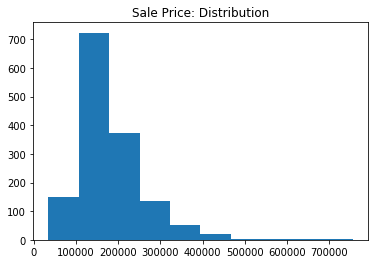

In [5]:
# Visualization of the target value
plt.hist(hprice['saleprice'])
plt.title('Sale Price: Distribution')
plt.show()

#### The target variable values are not normally distributed; it's skewed to right.
#### Now we try to find highly correlated numeric variables with the target value for choosing them for our model.

In [6]:
numeric_variables = hprice.select_dtypes(['int64','float64']).columns
hprice[numeric_variables].iloc[:,1:].corr().loc[:,"saleprice"].sort_values(ascending=False)

saleprice        1.000000
overallqual      0.790982
grlivarea        0.708624
garagecars       0.640409
garagearea       0.623431
totalbsmtsf      0.613581
firstflrsf       0.605852
fullbath         0.560664
totrmsabvgrd     0.533723
yearbuilt        0.522897
yearremodadd     0.507101
garageyrblt      0.486362
masvnrarea       0.477493
fireplaces       0.466929
bsmtfinsf1       0.386420
lotfrontage      0.351799
wooddecksf       0.324413
secondflrsf      0.319334
openporchsf      0.315856
halfbath         0.284108
lotarea          0.263843
bsmtfullbath     0.227122
bsmtunfsf        0.214479
bedroomabvgr     0.168213
screenporch      0.111447
poolarea         0.092404
mosold           0.046432
threessnporch    0.044584
bsmtfinsf2      -0.011378
bsmthalfbath    -0.016844
miscval         -0.021190
lowqualfinsf    -0.025606
yrsold          -0.028923
overallcond     -0.077856
mssubclass      -0.084284
enclosedporch   -0.128578
kitchenabvgr    -0.135907
Name: saleprice, dtype: float64

#### Because there is no bsolute big correlation value between variables negatively correlated, we choose variables which they have correlation greater than 0.6 with the target value.

#### We plot each categorical variable in relation with the respected average of the target variable to analize relations and choose the best ones for our model.

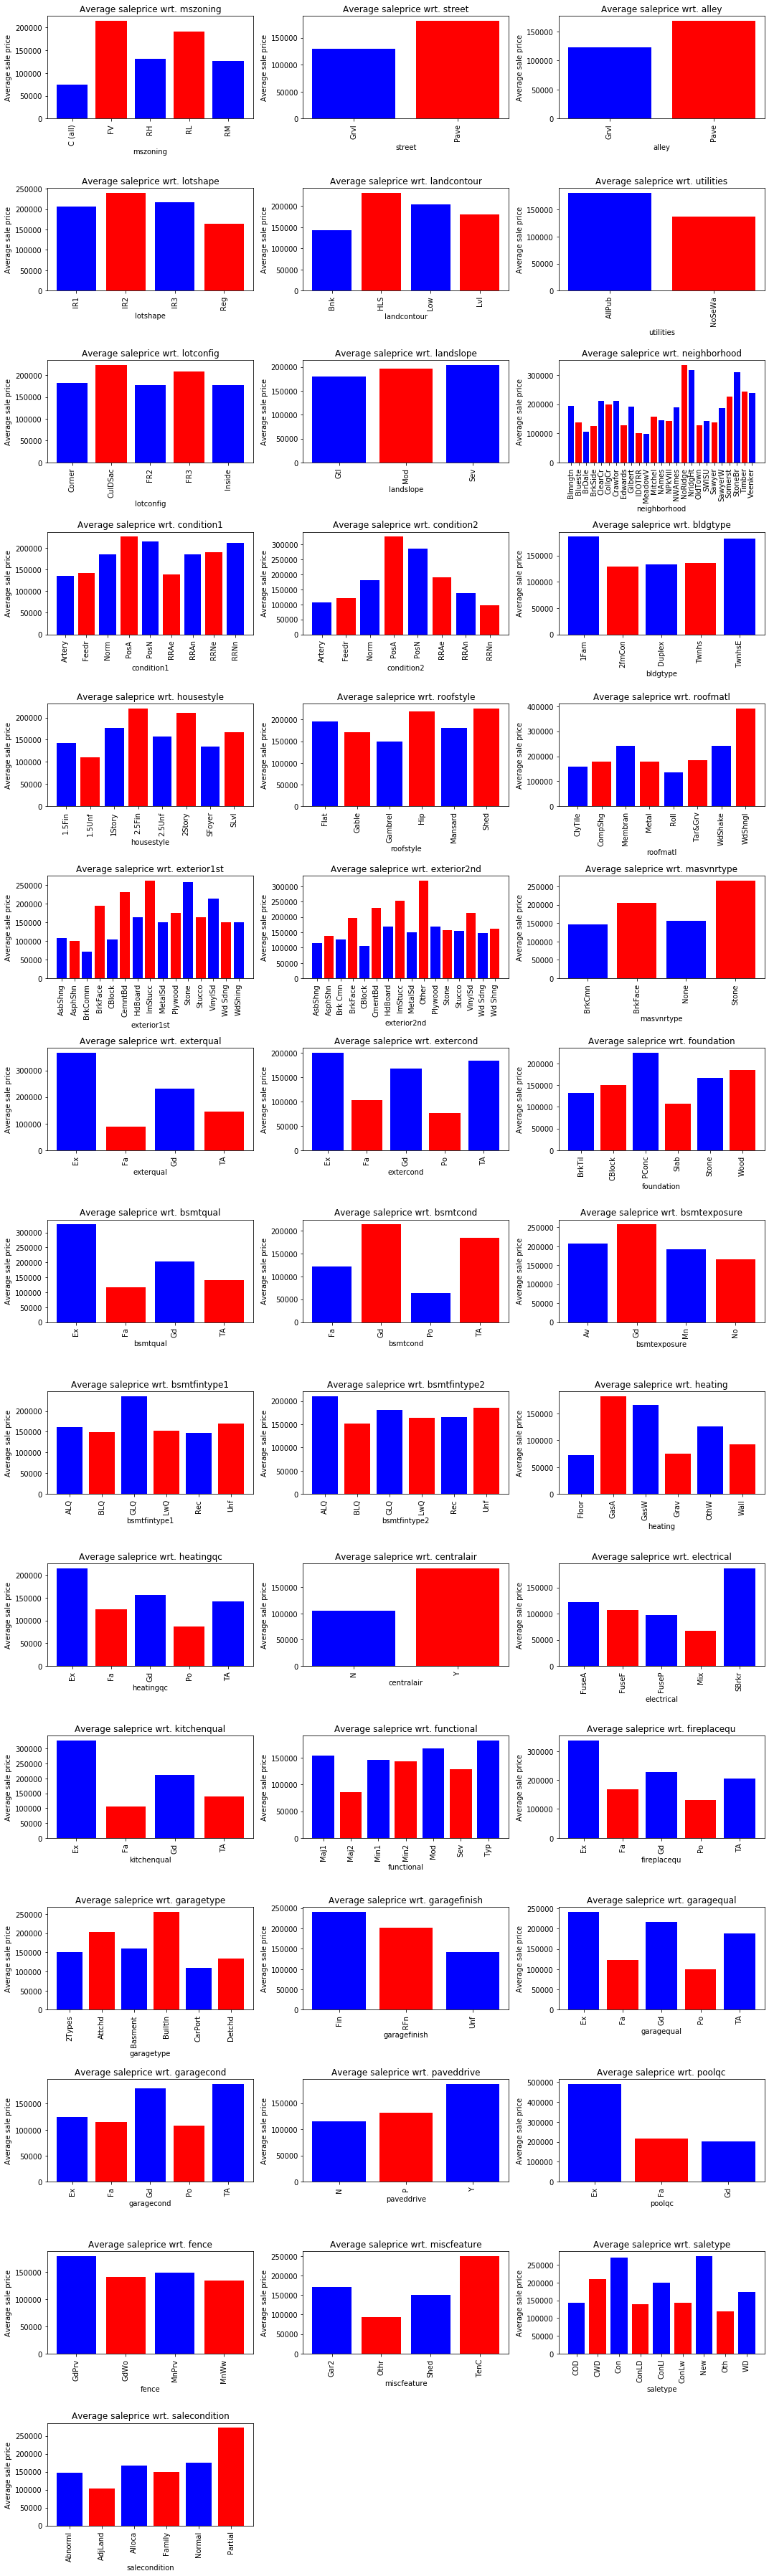

In [7]:
categorical_variables = hprice.select_dtypes(['object']).columns

plt.figure(figsize=(15,50))

for index, column in enumerate(categorical_variables):
    plt.subplot(15,3,index+1)
    plt.bar(hprice.groupby(column)["saleprice"].mean().index, hprice.groupby(column)["saleprice"].mean(),
           color=("blue","red"))
    plt.title("Average saleprice wrt. {}".format(column))
    plt.ylabel("Average sale price")
    plt.xlabel(column)
    plt.xticks(rotation='vertical')

plt.tight_layout()
plt.show()

We can see that almost all categorical variables give some variance with respect to average sale price. We choose mszoning and street as two categorical variables for our model.

#### Check for missing data:

In [8]:
selected_v = hprice[['overallqual', 'grlivarea', 'garagecars', 'garagearea', 'totalbsmtsf', 'firstflrsf', 'mszoning', 'street']]

total_missing = selected_v.isnull().sum().sort_values()
percent_missing = (selected_v.isnull().sum()/selected_v.isnull().count()).sort_values()
missing_data = pd.concat([total_missing, percent_missing], axis=1, keys=['Total', 'Percent'])

print(missing_data)


             Total  Percent
overallqual      0      0.0
grlivarea        0      0.0
garagecars       0      0.0
garagearea       0      0.0
totalbsmtsf      0      0.0
firstflrsf       0      0.0
mszoning         0      0.0
street           0      0.0


There are no missing values in our selected variables.

#### Visualizing of the continuous varables:

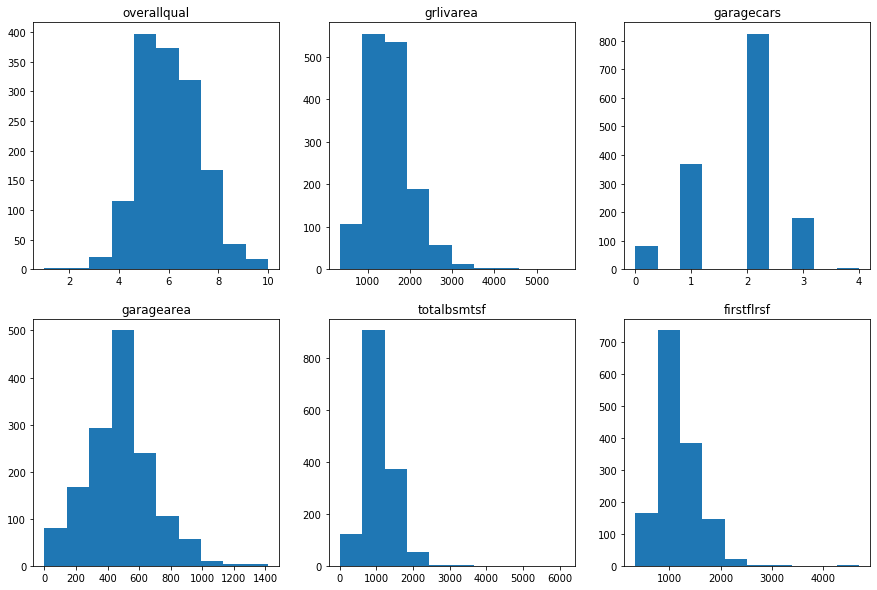

In [9]:
plt.figure(figsize=(15, 10))
for i, col in enumerate(selected_v.iloc[:,:6], 1):
    plt.subplot(2, 3, i)
    plt.hist(selected_v[col])
    plt.title(col)

Their distributions are not normal, but their values are not fra from to be normally disributed. So we won't apply any transformation. Also from the histograms we can see there are no outlires in any of the selected variables, and we don't need to winsorize them.

#### Preparing the selected categorical variables for using in our Model

In [10]:
hprice = pd.concat([hprice,pd.get_dummies(hprice.mszoning, prefix="mszoning", drop_first=True)], axis=1)
hprice = pd.concat([hprice,pd.get_dummies(hprice.street, prefix="street", drop_first=True)], axis=1)
dummy_columns = list(pd.get_dummies(hprice.mszoning, prefix="mszoning", drop_first=True).columns)
dummy_columns = dummy_columns + list(pd.get_dummies(hprice.street, prefix="street", drop_first=True).columns)

In [11]:
# show dummy columns
hprice[dummy_columns].head()

,mszoning_FV,mszoning_RH,mszoning_RL,mszoning_RM,street_Pave
0,0,0,1,0,1
1,0,0,1,0,1
2,0,0,1,0,1
3,0,0,1,0,1
4,0,0,1,0,1


# Regression Model

In [12]:
X = hprice[['overallqual', 'grlivarea', 'garagecars', 'garagearea', 'totalbsmtsf', 'firstflrsf'] + dummy_columns]
Y = hprice['saleprice']

X = sm.add_constant(X)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

results = sm.OLS(y_train, X_train).fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              saleprice   R-squared:                       0.768
Model:                            OLS   Adj. R-squared:                  0.766
Method:                 Least Squares   F-statistic:                     348.6
Date:                Sat, 23 Nov 2019   Prob (F-statistic):               0.00
Time:                        08:33:33   Log-Likelihood:                -13971.
No. Observations:                1168   AIC:                         2.797e+04
Df Residuals:                    1156   BIC:                         2.803e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -1.048e+05   2.06e+04     -5.078      

The R-squared and the adjusted R-squared of the model are 0.768 and 0.766 respectively. Hence, according to the R-squared, around 23.4% of the variance in the target variable is unexplained by the model. AIC and BIC scores are 27970 and 28030 respectively.

Now, let's evaluate the test set performance:

In [13]:
y_preds = results.predict(X_test)

y_preds.head()

135     180228.301026
1100      3979.341152
833     196330.044426
471     245119.041371
1123     80053.837826
dtype: float64

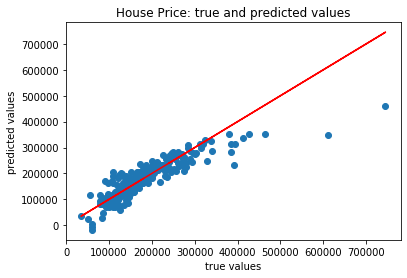

Mean absolute error of the prediction is: 25592.710618586258
Mean squared error of the prediction is: 1557737170.2418861
Root mean squared error of the prediction is: 39468.17921113015
Mean absolute percentage error of the prediction is: 15.594488764000058


In [14]:
plt.scatter(y_test, y_preds)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("House Price: true and predicted values")
plt.show()

print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds) / y_test)) * 100))

The performance of your model looks to be satisfactory. Now we check if we can get a better result by other types of linear regression.

# Lasso



In [15]:
alphas = [np.power(10.0,p) for p in np.arange(-10,40,1)]

lassoregr = LassoCV(alphas=alphas) 
lassoregr.fit(X_train, y_train)

# We are making predictions here
y_preds_train = lassoregr.predict(X_train)
y_preds_test = lassoregr.predict(X_test)

print("Best alpha value is: {}".format(lassoregr.alpha_))
print("R-squared of the model on the training set is: {}".format(lassoregr.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(lassoregr.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))


Best alpha value is: 10.0
R-squared of the model on the training set is: 0.7683304620285991
-----Test set statistics-----
R-squared of the model on the test set is: 0.767943476720023
Mean absolute error of the prediction is: 25609.494700392817
Mean squared error of the prediction is: 1557958826.9203773
Root mean squared error of the prediction is: 39470.987154115835
Mean absolute percentage error of the prediction is: 15.621759642751284


# Ridge

In [16]:
ridgeregr = RidgeCV(alphas=alphas) 
ridgeregr.fit(X_train, y_train)

# We are making predictions here
y_preds_train = ridgeregr.predict(X_train)
y_preds_test = ridgeregr.predict(X_test)

print("Best alpha value is: {}".format(lassoregr.alpha_))
print("R-squared of the model on the training set is: {}".format(ridgeregr.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(ridgeregr.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))


Best alpha value is: 10.0
R-squared of the model on the training set is: 0.7681724442183551
-----Test set statistics-----
R-squared of the model on the test set is: 0.7680617024440491
Mean absolute error of the prediction is: 25584.5381242509
Mean squared error of the prediction is: 1557165094.394732
Root mean squared error of the prediction is: 39460.93124084544
Mean absolute percentage error of the prediction is: 15.670694661615986


# ElasticNet

In [17]:
elasticregr = ElasticNetCV(alphas=alphas) 
elasticregr.fit(X_train, y_train)

# We are making predictions here
y_preds_train = elasticregr.predict(X_train)
y_preds_test = elasticregr.predict(X_test)

print("Best alpha value is: {}".format(lassoregr.alpha_))
print("R-squared of the model on the training set is: {}".format(elasticregr.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(elasticregr.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

Best alpha value is: 10.0
R-squared of the model on the training set is: 0.7682287857552078
-----Test set statistics-----
R-squared of the model on the test set is: 0.7678799816159789
Mean absolute error of the prediction is: 25612.17515949668
Mean squared error of the prediction is: 1558385114.259399
Root mean squared error of the prediction is: 39476.38679336546
Mean absolute percentage error of the prediction is: 15.682188571995697


According to the results Ridge regression has the best results. The training set's R-squared and the test set's R-squared are closer respecte the other two linear regressions, and except for MAPE has the lowest values in MAE, MSE, and RMSE. Since we are interested to have lower values in these statistics, the Ridge Linear Regression is the best model.  

In [35]:
interest_rate = {2010: 0.0325,
                 2009: 0.0325, 
                 2008: 0.06,
                 2007: 0.0825,
                 2006: 0.075}

for r in range(len(interest_rate)):
    year = hprice['yrsold']
    hprice['year_interest_rate'] = interest_rate[year]

TypeError: 'Series' objects are mutable, thus they cannot be hashed

In [34]:
for i in range(len(hprice)) :
    if hprice['yrsold'] == 2010:
        hprice['year_interest_rate'] = 0.0325
    

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [32]:

hprice[['yrsold','year_interest_rate']]

KeyError: "['year_interest_rate'] not in index"